# Independent Tests for Bounding Box Validation on YOLO Model

Using the Thermal Model for testing the Bounding Box Validation (BBV) Pipeline & Model on a live YOLO model, using manually counted clips.

In [1]:
%pip install --upgrade pip
%pip install -r ../requirements.txt  # Installing dependencies

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
''' Dependencies '''

# Core libraries
import cv2
import supervision as sv
import numpy as np
from ultralytics import YOLO
from utils.thermal_frame_to_temp import result_to_temp_frame
from utils.group_bounding_boxes import group_and_merge_bounding_boxes
from validate_bounding_box import get_box_count
# from tkinter.filedialog import askopenfilename, askdirectory
import joblib
from collections import Counter

# SVM and model training
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Synthesizing Data
from imblearn.over_sampling import SMOTE

# ANN
from tensorflow import keras
from tensorflow.keras import layers

# Better exception handling and helpers
import traceback
import pprint
import datetime
import os
import time

## Deriving Ground Truth Video & Labeling

Given a clip with a known count, save the known count for comparison.

In [3]:
TRUE_COUNT = 75  # True count for the given clip
# FILE_NAME:str = "data/Brennen's-Thermal-Video/Top-Belt(Iron)-01-Testing-TRUE_COUNT-98.mp4" # Global variable to store the selected file name if applicable

## Pulling in the saved model & declaring pipeline

In [4]:
BBV_MODEL = joblib.load('./models/thermal_chick_counting_rf_model_fit.pkl')  # Load the pre-trained BBV model
BBV_STANDARD_SCALER = joblib.load('./models/thermal_chick_counting_rf_scaler.pkl')  # Load the pre-fitted StandardScaler
YOLO_MODEL = YOLO('./models/new_iron.pt')  # Load the pre-trained YOLO model

# Declare the pipeline
BBV_PIPELINE = Pipeline([
    ('scaler', BBV_STANDARD_SCALER),
    ('classifier', BBV_MODEL)
])

# Validate that the model properly loaded
BBV_PIPELINE

,steps,"[('scaler', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,4


## Run the YOLO Model with Thermal Pipeline 

In [ ]:
def get_line_from_video_frame(frame):
    frame_height, frame_width = frame.shape[:2]
    # Draw a horizontal line across the middle of the frame
    line_start = (frame_width, frame_height // 2)
    line_end = (0, frame_height // 2)
    return [line_start, line_end]

def chick_counting(video_path, output_path, line_points, verbose = False):

    # Grab a sample frame so we know video size
    generator = sv.get_video_frames_generator(video_path)
    frame = next(generator)

    # Set up video writer with same FPS/size as input
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame.shape[1], frame.shape[0]))
    if not out.isOpened():
        print("Error: Could not open video writer")
        return

    # Init tracker and helpers
    byte_tracker = sv.ByteTrack()
    trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

    # Create the counting line
    line_zone = sv.LineZone(start=sv.Point(*line_points[0]), end=sv.Point(*line_points[1]))

    # Load custom YOLO model
    model = YOLO_MODEL
    
    # Annotators for boxes + labels
    BOUNDING_BOX_ANNOTATOR = sv.BoxAnnotator(thickness=2, color=sv.Color(0, 255, 0))
    LABEL_ANNOTATOR = sv.LabelAnnotator(text_scale=1)

    # Counters
    frame_count = 0
    total_count = 0
    total_count_bbv = 0
    all_counted_ids = set()  # keep track of already-counted trackers
    all_counted_ids_bbv = set()  # Seperate list for the bounding box validation
    
    # Constants to hold high and low thermal temperatures for denormalization
    prev_hi = None
    prev_lo = None

    try:
        generator = sv.get_video_frames_generator(video_path)

        for frame in generator:
            frame_count += 1
            if verbose:
                print(f"Processing frame {frame_count}")

            # Run YOLO on frame
            results = model(frame)[0]
            
            # Get the frame image as denormalized numpy array
            try:
                temp_arr, prev_hi, prev_lo = result_to_temp_frame(
                    results,
                    frame_idx = frame_count,
                    prev_hi_val = prev_hi,
                    prev_lo_val = prev_lo
                )
            except Exception as e:
                if verbose:
                    print(f"Warning: Could not convert frame {frame_count} to temperature array. Skipping BBV for this frame.")
                if prev_hi is not None and prev_lo is not None:
                    temp_arr = np.zeros_like(frame[..., 0], dtype=np.float32)  # reuse last temp_arr shape
                else:
                    temp_arr = None

            # Convert results to supervision Detections
            detections = sv.Detections.from_ultralytics(results)

            # Sensitivity for declaring a box as "nested" (e.g. 0.9 means inner must have at least 90% of its area inside outer)
            NESTED_THRESHOLD = 0.9  

            # Get indicies of all boxes
            contained_indices = set()
            boxes = detections.xyxy

            for i, outer in enumerate(boxes):
                x1o, y1o, x2o, y2o = outer
                outer_area = max(0, (x2o - x1o)) * max(0, (y2o - y1o))

                for j, inner in enumerate(boxes):
                    if i == j:
                        continue
                    x1i, y1i, x2i, y2i = inner
                    inner_area = max(0, (x2i - x1i)) * max(0, (y2i - y1i))

                    # Intersection box
                    inter_x1 = max(x1o, x1i)
                    inter_y1 = max(y1o, y1i)
                    inter_x2 = min(x2o, x2i)
                    inter_y2 = min(y2o, y2i)

                    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)

                    # Ratio of inner covered by outer
                    if inner_area > 0 and (inter_area / inner_area) >= NESTED_THRESHOLD:
                        contained_indices.add(j)


            # Update tracker with detections
            detections = byte_tracker.update_with_detections(detections)
            if verbose:
                print("Tracker IDs this frame:", detections.tracker_id)

            # See if any trackers crossed the line
            crossed_in_flags, crossed_out_flags = line_zone.trigger(detections)

            # Only count new IDs that cross "in"
            for i, crossed in enumerate(crossed_in_flags):
                if crossed:
                    tracker_id = detections.tracker_id[i]
                    
                    if tracker_id is None: continue  # Skip if no tracker ID
                    
                    # YOLO tracker
                    if tracker_id not in all_counted_ids:
                        total_count += 1
                        all_counted_ids.add(tracker_id)
                        if verbose:
                            print(f"New Chick crossed the line! ID {tracker_id}, Total count: {total_count}")
                    
                    # Bounding Box Validation tracker
                    if tracker_id not in all_counted_ids_bbv:
                        # Get the merged bounding boxes for overlaps in this frame
                        group_and_merge_bounding_boxes_result = group_and_merge_bounding_boxes(
                            xyxy = detections.xyxy, 
                            tracker_ids = detections.tracker_id.tolist(), 
                            target_tracker_id = tracker_id,
                            iou_thresh = 0.10,  # Low threshold to catch even slight overlaps
                        )
                        if group_and_merge_bounding_boxes_result is None: continue  # Skip if no valid group found
                        merged_box_group, grouped_tracker_ids = group_and_merge_bounding_boxes_result
                        all_counted_ids_bbv.update(grouped_tracker_ids)  # Add all grouped IDs to counted list
                        # Using the merged group, add to the total BBV count
                        total_count_bbv += get_box_count(
                            pipeline=BBV_PIPELINE,
                            temperature_frame=temp_arr,
                            box=merged_box_group
                        )
                        if verbose:
                            print(f"New BBV Chick(s) crossed the line! Grouped IDs {grouped_tracker_ids}, BBV Total count: {total_count_bbv}")

            # Assign labels + colors depending on nesting
            labels = []
            colors = []
            for i, tracker_id in enumerate(detections.tracker_id):
                if i in contained_indices:
                    labels.append(f"#{tracker_id} nested")
                    colors.append(sv.Color.RED)
                else:
                    labels.append(f"#{tracker_id} chick")
                    colors.append(sv.Color.GREEN)

            # Draw tracker trails
            annotated_frame = trace_annotator.annotate(scene=frame.copy(), detections=detections)

            # Draw bounding boxes manually with chosen colors
            for i, box in enumerate(detections.xyxy):
                color = colors[i] if i < len(colors) else sv.Color.GREEN
                x1, y1, x2, y2 = map(int, box)
                cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), color.as_bgr(), 2)

            # Draw labels
            # Draw smaller labels with smaller background rectangles
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.4  # significantly smaller
            thickness = 1
            pad = 3

            for i, lbl in enumerate(labels):
                x1, y1, x2, y2 = map(int, detections.xyxy[i])
                text_size, _ = cv2.getTextSize(lbl, font, font_scale, thickness)
                text_w, text_h = text_size

                # Position label above box if space, otherwise below
                if y1 - text_h - 2 * pad > 0:
                    rect_tl = (x1, y1 - text_h - 2 * pad)
                    rect_br = (x1 + text_w + 2 * pad, y1)
                    text_org = (x1 + pad, y1 - pad)
                else:
                    rect_tl = (x1, y1)
                    rect_br = (x1 + text_w + 2 * pad, y1 + text_h + 2 * pad)
                    text_org = (x1 + pad, y1 + text_h + pad)

                # Background color: use tracker color if available, else black
                bg_color = colors[i].as_bgr() if i < len(colors) else (0, 0, 0)
                # Choose text color for contrast
                text_color = (0, 0, 0) if sum(bg_color) > 382 else (255, 255, 255)

                cv2.rectangle(annotated_frame, rect_tl, rect_br, bg_color, cv2.FILLED)
                cv2.putText(annotated_frame, lbl, text_org, font, font_scale, text_color, thickness, cv2.LINE_AA)

            # Draw the counting line
            cv2.line(annotated_frame, line_points[0], line_points[1], (0, 0, 255), 2)

            # Overlay YOLO total count
            cv2.putText(
                annotated_frame,
                f'Total Count: {total_count}',
                (10, 50),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0, 255, 0),
                2,
                cv2.LINE_AA
            )
            
            # Overlay BBV total count
            cv2.putText(
                annotated_frame,
                f'BBV Total Count: {total_count_bbv}',
                (10, 80),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (255, 0, 0),
                2,
                cv2.LINE_AA
            )
            
            # Overlay True total count
            cv2.putText(
                annotated_frame,
                f'True Total Count: {TRUE_COUNT}',
                (10, 110),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0, 0, 255),
                2,
                cv2.LINE_AA
            )

            # Write out annotated frame
            out.write(annotated_frame)
            
    except Exception as e:
        # Detailed exception logging
        print("=== Exception while processing video frames ===")
        print("Time:", datetime.datetime.now().isoformat())
        print("Exception type:", type(e).__name__)
        print("Exception message:", str(e))
        print("Full traceback:")
        print(traceback.format_exc())

    finally:
        # Clean up writer and windows
        out.release()
        cv2.destroyAllWindows()
        print(f"Total Frames Processed: {frame_count}\nYOLO Count = {total_count}, BBV Total = {total_count_bbv}, True Count = {TRUE_COUNT}")
        if verbose:
            print(f"LineZone internal count (for reference): in={line_zone.in_count}, out={line_zone.out_count}")


if __name__ == "__main__":
    import tkinter as tk
    from tkinter.filedialog import askopenfilename, askdirectory
    tk.Tk().withdraw()

    # Pick input video + output folder with file dialogs
    SOURCE_VIDEO_PATH = askopenfilename()
    print("User chose:", SOURCE_VIDEO_PATH)

    folder_path = askdirectory()
    print("Output folder:", folder_path)

    # Build output filename
    filename_no_ext = SOURCE_VIDEO_PATH.split('/')[-1].rsplit('.', 1)[0]
    OUTPUT_PATH = f"{folder_path}/{filename_no_ext}-outputfile(colored).mp4"
    print("Output path:", OUTPUT_PATH)

    # Grab a frame to define the line
    cap = cv2.VideoCapture(SOURCE_VIDEO_PATH)
    ret, frame = cap.read()
    if not ret:
        print("Failed to read the video")
        exit()
    cap.release()

    line_points = get_line_from_video_frame(frame)
    print("Line points:", line_points)

    # Only run if line points are valid
    if len(line_points) == 2:
        chick_counting(SOURCE_VIDEO_PATH, OUTPUT_PATH, line_points, verbose=True)
    else:
        print("Error: Not enough points to define the counting line.")

## BBV Pipeline v2 - No Bounding Box Grouping

Similar to the functionality above, however this will use a model that is trained on singular bounding boxes (no grouping)

In [5]:
''' Determine video/clip to test '''
TRUE_COUNT = 75  # True count for the given clip

''' Load the relevant models and scalers '''
BBV_MODEL_NO_GROUPING = joblib.load('./models/thermal_chick_counting_NOGROUP_rf_model_fit.pkl')  # Load the pre-trained BBV model
BBV_STANDARD_SCALER_NO_GROUPING = joblib.load('./models/thermal_chick_counting_NOGROUP_rf_scaler.pkl')  # Load the pre-fitted StandardScaler
YOLO_MODEL = YOLO('./models/new_iron.pt')  # Load the pre-trained YOLO model

# Declare the pipeline
BBV_PIPELINE_NO_GROUPING = Pipeline([
    ('scaler', BBV_STANDARD_SCALER_NO_GROUPING),
    ('classifier', BBV_MODEL_NO_GROUPING)
])

# Validate that the model properly loaded
BBV_PIPELINE_NO_GROUPING

,steps,"[('scaler', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_estimators,150
,criterion,'gini'
,max_depth,None
,min_samples_split,5


In [6]:
def get_line_from_video_frame(frame):
    frame_height, frame_width = frame.shape[:2]
    # Draw a horizontal line across the middle of the frame
    line_start = (frame_width, frame_height // 2)
    line_end = (0, frame_height // 2)
    return [line_start, line_end]

MIN_BOX_AREA = 900  # Minimum area of bounding box to consider for BBV

def chick_counting_bbv(
    video_path,  # Input video path
    output_path,  # Output video path
    line_points,  # Points defining the counting line [(x1, y1), (x2, y2)]
    verbose: bool = False,  # Verbose output during processing
    yolo_conf: float = 0.10,  # Confidence parameter to use for the YOLO model predictions
    yolo_iou: float = 0.9,  # IOU parameter to use for the YOLO model predictions
    TRUE_COUNT: int = 75,  # Count displayed on the clip (default value)
    FRAME_START: int = 0,  # Start processing from this frame
    FRAME_END: int = None,  # None will process to end of video
    MIN_BOX_AREA: int = 900  # Minimum area of bounding box to consider for BBV (default value)
) -> int:

    # Grab a sample frame so we know video size
    generator = sv.get_video_frames_generator(video_path)
    frame = next(generator)

    # Set up video writer with same FPS/size as input
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame.shape[1], frame.shape[0]))
    if not out.isOpened():
        print("Error: Could not open video writer")
        return 0  # Return 0 if video writer fails

    # Init tracker and helpers
    byte_tracker = sv.ByteTrack()
    trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

    # Create the counting line
    line_zone = sv.LineZone(start=sv.Point(*line_points[0]), end=sv.Point(*line_points[1]))

    # Load custom YOLO model
    model = YOLO_MODEL
    
    # Annotators for boxes + labels
    BOUNDING_BOX_ANNOTATOR = sv.BoxAnnotator(thickness=2, color=sv.Color(0, 255, 0))
    LABEL_ANNOTATOR = sv.LabelAnnotator(text_scale=1)

    # Counters
    frame_count = 0
    total_count = 0
    total_count_bbv = 0
    all_counted_ids = set()  # keep track of already-counted trackers
    all_counted_ids_bbv = set()  # Seperate list for the bounding box validation
    
    # Constants to hold high and low thermal temperatures for denormalization
    prev_hi = None
    prev_lo = None

    try:
        generator = sv.get_video_frames_generator(video_path)

        for frame in generator:
            frame_count += 1
            if verbose:
                print(f"Processing frame {frame_count}")

            # Skip frames outside the specified range
            if frame_count < FRAME_START or (FRAME_END is not None and frame_count > FRAME_END):
                continue

            # Run YOLO on frame with the specified parameters
            results = model(frame, conf=yolo_conf, iou=yolo_iou, verbose=False)[0]
            
            # Get the frame image as denormalized numpy array
            try:
                temp_arr, prev_hi, prev_lo = result_to_temp_frame(
                    results,
                    frame_idx = frame_count,
                    prev_hi_val = prev_hi,
                    prev_lo_val = prev_lo
                )
            except Exception as e:
                if verbose:
                    print(f"Warning: Could not convert frame {frame_count} to temperature array. Skipping BBV for this frame.")
                if prev_hi is not None and prev_lo is not None:
                    temp_arr = np.zeros_like(frame[..., 0], dtype=np.float32)  # reuse last temp_arr shape
                else:
                    temp_arr = None

            # Convert results to supervision Detections
            detections = sv.Detections.from_ultralytics(results)

            # Sensitivity for declaring a box as "nested" (e.g. 0.9 means inner must have at least 90% of its area inside outer)
            NESTED_THRESHOLD = 0.9  

            # Get indicies of all boxes
            contained_indices = set()
            boxes = detections.xyxy

            for i, outer in enumerate(boxes):
                x1o, y1o, x2o, y2o = outer
                outer_area = max(0, (x2o - x1o)) * max(0, (y2o - y1o))

                for j, inner in enumerate(boxes):
                    if i == j:
                        continue
                    x1i, y1i, x2i, y2i = inner
                    inner_area = max(0, (x2i - x1i)) * max(0, (y2i - y1i))

                    # Intersection box
                    inter_x1 = max(x1o, x1i)
                    inter_y1 = max(y1o, y1i)
                    inter_x2 = min(x2o, x2i)
                    inter_y2 = min(y2o, y2i)

                    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)

                    # Ratio of inner covered by outer
                    if inner_area > 0 and (inter_area / inner_area) >= NESTED_THRESHOLD:
                        contained_indices.add(j)


            # Update tracker with detections
            detections = byte_tracker.update_with_detections(detections)
            if verbose:
                print("Tracker IDs this frame:", detections.tracker_id)

            # See if any trackers crossed the line
            crossed_in_flags, crossed_out_flags = line_zone.trigger(detections)

            # Only count new IDs that cross "in"
            for i, crossed in enumerate(crossed_in_flags):
                if crossed:
                    tracker_id = detections.tracker_id[i]
                    
                    if tracker_id is None: continue  # Skip if no tracker ID
                    
                    # Track bounding boxes
                    if tracker_id not in all_counted_ids:
                        # Add to the YOLO total count
                        total_count += 1
                        all_counted_ids.add(tracker_id)
                        
                        # Determine area to filter out unreasonably small boxes
                        x1, y1, x2, y2 = map(int, detections.xyxy[i])
                        w = max(0, x2 - x1)
                        h = max(0, y2 - y1)
                        area = w * h
                        
                        # Initialize cur_box_count to 0
                        cur_box_count = 0
                            
                        # Run the BBV on this bounding box if it's large enough
                        if area > MIN_BOX_AREA:
                            cur_box_count = get_box_count(
                                pipeline=BBV_PIPELINE_NO_GROUPING,
                                temperature_frame=temp_arr,
                                box=(x1, y1, x2, y2)
                            )
                            print(f"Tracker ID {tracker_id} with box area {area} yielded BBV count: {cur_box_count}")
                            total_count_bbv += cur_box_count
                        
                        if verbose:
                            print(f"New Chick crossed the line! ID {tracker_id}, Chicks in bounding box: {cur_box_count}, Total YOLO count: {total_count}, Total BBV count: {total_count_bbv}")

            # Assign labels + colors depending on nesting
            labels = []
            colors = []
            for i, tracker_id in enumerate(detections.tracker_id):
                if i in contained_indices:
                    labels.append(f"#{tracker_id} nested")
                    colors.append(sv.Color.RED)
                else:
                    labels.append(f"#{tracker_id} chick")
                    colors.append(sv.Color.GREEN)

            # Draw tracker trails
            annotated_frame = trace_annotator.annotate(scene=frame.copy(), detections=detections)

            # Draw bounding boxes manually with chosen colors
            for i, box in enumerate(detections.xyxy):
                color = colors[i] if i < len(colors) else sv.Color.GREEN
                x1, y1, x2, y2 = map(int, box)
                cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), color.as_bgr(), 2)

            # Draw labels
            # Draw smaller labels with smaller background rectangles
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.4  # significantly smaller
            thickness = 1
            pad = 3

            for i, lbl in enumerate(labels):
                x1, y1, x2, y2 = map(int, detections.xyxy[i])
                width = max(0, x2 - x1)
                height = max(0, y2 - y1)
                text_size, _ = cv2.getTextSize(lbl, font, font_scale, thickness)
                text_w, text_h = text_size

                # Position label above box if space, otherwise below
                if y1 - text_h - 2 * pad > 0:
                    rect_tl = (x1, y1 - text_h - 2 * pad)
                    rect_br = (x1 + text_w + 2 * pad, y1)
                    text_org = (x1 + pad, y1 - pad)
                else:
                    rect_tl = (x1, y1)
                    rect_br = (x1 + text_w + 2 * pad, y1 + text_h + 2 * pad)
                    text_org = (x1 + pad, y1 + text_h + pad)

                # Background color: use tracker color if available, else black
                bg_color = colors[i].as_bgr() if i < len(colors) else (0, 0, 0)
                # Choose text color for contrast
                text_color = (0, 0, 0) if sum(bg_color) > 382 else (255, 255, 255)

                cv2.rectangle(annotated_frame, rect_tl, rect_br, bg_color, cv2.FILLED)
                cv2.putText(annotated_frame, lbl, text_org, font, font_scale, text_color, thickness, cv2.LINE_AA)

            # Draw the counting line
            cv2.line(annotated_frame, line_points[0], line_points[1], (0, 0, 255), 2)

            # Overlay YOLO total count
            cv2.putText(
                annotated_frame,
                f'Total Count: {total_count}',
                (10, 50),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0, 255, 0),
                2,
                cv2.LINE_AA
            )
            
            # Overlay BBV total count
            cv2.putText(
                annotated_frame,
                f'BBV Total Count: {total_count_bbv}',
                (10, 80),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (255, 0, 0),
                2,
                cv2.LINE_AA
            )
            
            # Overlay True total count
            cv2.putText(
                annotated_frame,
                f'True Total Count: {TRUE_COUNT}',
                (10, 110),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0, 0, 255),
                2,
                cv2.LINE_AA
            )

            # Write out annotated frame
            out.write(annotated_frame)
            
    except Exception as e:
        # Detailed exception logging
        print("=== Exception while processing video frames ===")
        print("Time:", datetime.datetime.now().isoformat())
        print("Exception type:", type(e).__name__)
        print("Exception message:", str(e))
        print("Full traceback:")
        print(traceback.format_exc())

    finally:
        # Clean up writer and windows
        out.release()
        cv2.destroyAllWindows()
        print(f"Total Frames Processed: {frame_count}\nYOLO Count = {total_count}, BBV Total = {total_count_bbv}, True Count = {TRUE_COUNT}")
        if verbose:
            print(f"LineZone internal count (for reference): in={line_zone.in_count}, out={line_zone.out_count}")
        return total_count_bbv  # Return the BBV total count for reference

'''
if __name__ == "__main__":
    import tkinter as tk
    from tkinter.filedialog import askopenfilename, askdirectory
    tk.Tk().withdraw()

    # Pick input video + output folder with file dialogs
    SOURCE_VIDEO_PATH = askopenfilename()
    print("User chose:", SOURCE_VIDEO_PATH)

    folder_path = askdirectory()
    print("Output folder:", folder_path)

    # Build output filename
    filename_no_ext = SOURCE_VIDEO_PATH.split('/')[-1].rsplit('.', 1)[0]
    OUTPUT_PATH = f"{folder_path}/{filename_no_ext}-PIPELINETEST-outputfile(colored).mp4"
    print("Output path:", OUTPUT_PATH)

    # Grab a frame to define the line
    cap = cv2.VideoCapture(SOURCE_VIDEO_PATH)
    ret, frame = cap.read()
    if not ret:
        print("Failed to read the video")
        exit()
    cap.release()

    line_points = get_line_from_video_frame(frame)
    print("Line points:", line_points)

    # Only run if line points are valid
    if len(line_points) == 2:
        chick_counting_bbv(SOURCE_VIDEO_PATH, OUTPUT_PATH, line_points, verbose=False)
    else:
        print("Error: Not enough points to define the counting line.")
'''

'\nif __name__ == "__main__":\n    import tkinter as tk\n    from tkinter.filedialog import askopenfilename, askdirectory\n    tk.Tk().withdraw()\n\n    # Pick input video + output folder with file dialogs\n    SOURCE_VIDEO_PATH = askopenfilename()\n    print("User chose:", SOURCE_VIDEO_PATH)\n\n    folder_path = askdirectory()\n    print("Output folder:", folder_path)\n\n    # Build output filename\n    filename_no_ext = SOURCE_VIDEO_PATH.split(\'/\')[-1].rsplit(\'.\', 1)[0]\n    OUTPUT_PATH = f"{folder_path}/{filename_no_ext}-PIPELINETEST-outputfile(colored).mp4"\n    print("Output path:", OUTPUT_PATH)\n\n    # Grab a frame to define the line\n    cap = cv2.VideoCapture(SOURCE_VIDEO_PATH)\n    ret, frame = cap.read()\n    if not ret:\n        print("Failed to read the video")\n        exit()\n    cap.release()\n\n    line_points = get_line_from_video_frame(frame)\n    print("Line points:", line_points)\n\n    # Only run if line points are valid\n    if len(line_points) == 2:\n       

## Massive YOLO Parameter Tests

Using the bounding-box validation YOLO logic, we can use our pretrained model to test performance on multiple YOLO parameters to find the optimal fit for a given video.

In [8]:
import os
import cv2
import itertools
import pickle
import pandas as pd

# Helper to format floats when saving results
def format_float(x: float) -> str:
    return f"{int(round(x*100)):03d}"

''' Define constants and parameter grid '''
# Constants for the chosen video clip
FRAME_START = 0  # Start processing from this frame
FRAME_END = 2095  # Process up until frame 2095 (known count)
TRUE_COUNT_PARAM_TEST = 245  # True count for the given clip

# File Paths
SOURCE_VIDEO_PATH: str = "../data/Brennen's-Thermal-Video/Top Belt(Iron) 02.mp4"  # Path to known input video clip
base_output_path: str = "./bbv-test-results3/"  # Will append specific filenames during execution

# Make the directory if it doesn't exist
if not os.path.exists(base_output_path):
    os.makedirs(base_output_path)

# Paths for persistent storage
results_csv_path = f"{base_output_path}/bbv_test_results_summary.csv"
results_csv_path_complete = f"{base_output_path}/bbv_test_results_summary-complete.csv"
results_pickle_path = f"{base_output_path}/bbv_test_results_summary.pkl"

# Defining a parameter grid for YOLO (slightly tweaked)
yolo_param_grid = {
    'conf': [0.05, 0.45, 0.50],
    'iou': [0.30, 0.35],
    'min_box_area': [1000, 1100, 1150, 1200],
}

# Defining a list to hold results
results_list = []

# Attempt to resume from existing pickle (if it exists)
if os.path.exists(results_pickle_path):
    try:
        with open(results_pickle_path, "rb") as f:
            results_list = pickle.load(f)
        print(f"Loaded {len(results_list)} previous results from pickle.")
    except Exception as e:
        print(f"Warning: Could not load existing pickle file: {e}")
        results_list = []

# Track which parameter combinations have already been processed
completed_params = {
    (r['conf'], r['iou'], r['min_box_area'])
    for r in results_list
    if all(k in r for k in ['conf', 'iou', 'min_box_area'])
}

# Track whether the CSV already exists (for header handling)
csv_exists = os.path.exists(results_csv_path)

# Validating the clip has successfully loaded 
cap = cv2.VideoCapture(SOURCE_VIDEO_PATH)  # Grab a frame to define the line
ret, frame = cap.read()
if not ret:
    print("Failed to read the video")
    raise ValueError("Could not read video file. Please check SOURCE_VIDEO_PATH.")
cap.release()

line_points = get_line_from_video_frame(frame)
print("Line points:", line_points)

# Only run if line points are valid
if len(line_points) == 2:
    # Loop through all combinations of parameters
    for conf, iou, min_box_area in itertools.product(
        yolo_param_grid['conf'],
        yolo_param_grid['iou'],
        yolo_param_grid['min_box_area']
    ):
        # Skip combinations we've already processed
        if (conf, iou, min_box_area) in completed_params:
            print(f"Skipping already completed combo: conf={conf}, iou={iou}, min_box_area={min_box_area}")
            continue

        print(f"Testing with conf={conf}, iou={iou}, min_box_area={min_box_area}")

        # Build output filename
        OUTPUT_PATH = f"{base_output_path}/bbv_test_conf{format_float(conf)}_iou{format_float(iou)}_minbox{min_box_area}.mp4"
        print("Output path:", OUTPUT_PATH)

        try:
            # Run the counting with the current parameters
            cur_total_bbv_count = chick_counting_bbv(
                video_path=SOURCE_VIDEO_PATH,
                output_path=OUTPUT_PATH,
                line_points=line_points,
                verbose=False,
                yolo_conf=conf,
                yolo_iou=iou,
                TRUE_COUNT=TRUE_COUNT_PARAM_TEST,
                FRAME_START=FRAME_START,
                FRAME_END=FRAME_END,
                MIN_BOX_AREA=min_box_area
            )

            # Create the result record
            result_record = {
                'conf': conf,
                'iou': iou,
                'min_box_area': min_box_area,
                'bbv_count': cur_total_bbv_count,
                'true_count': TRUE_COUNT_PARAM_TEST,
                'error': abs(cur_total_bbv_count - TRUE_COUNT_PARAM_TEST)
            }

        except Exception as e:
            # If something goes wrong for this combo, record the error instead of crashing
            print(f"Error for conf={conf}, iou={iou}, min_box_area={min_box_area}: {e}")
            result_record = {
                'conf': conf,
                'iou': iou,
                'min_box_area': min_box_area,
                'bbv_count': None,
                'true_count': TRUE_COUNT_PARAM_TEST,
                'error': None,
                'error_message': str(e)
            }

        # Store the results in-memory
        results_list.append(result_record)
        completed_params.add((conf, iou, min_box_area))

        # Append this single result to the CSV (robust to interruptions)
        row_df = pd.DataFrame([result_record])
        row_df.to_csv(
            results_csv_path,
            mode='a',
            header=not csv_exists,  # write header only if file didn't exist before
            index=False
        )
        csv_exists = True  # From now on, header is already written

        # Update the pickle after each iteration (also robust to interruptions)
        try:
            with open(results_pickle_path, "wb") as f:
                pickle.dump(results_list, f)
        except Exception as e:
            print(f"Warning: Failed to save pickle: {e}")

else:
    print("Error: Not enough points to define the counting line.")
    
# After all tests, save results to a CSV
results_df = pd.DataFrame(results_list)
results_df.to_csv(results_csv_path_complete, index=False)
print(f"\nFinal results saved to: {results_csv_path}")
print(f"Total parameter combinations tested: {len(results_list)}")


Line points: [(256, 171), (0, 171)]
Testing with conf=0.05, iou=0.3, min_box_area=1000
Output path: ./bbv-test-results3//bbv_test_conf005_iou030_minbox1000.mp4
Tracker ID 4 with box area 1650 yielded BBV count: 1
Tracker ID 7 with box area 1674 yielded BBV count: 1
Tracker ID 4 with box area 1650 yielded BBV count: 1
Tracker ID 7 with box area 1674 yielded BBV count: 1
Tracker ID 19 with box area 2120 yielded BBV count: 1
Tracker ID 23 with box area 1599 yielded BBV count: 1
Tracker ID 19 with box area 2120 yielded BBV count: 1
Tracker ID 23 with box area 1599 yielded BBV count: 1
Tracker ID 18 with box area 1891 yielded BBV count: 1
Tracker ID 18 with box area 1891 yielded BBV count: 1
Tracker ID 6 with box area 1870 yielded BBV count: 1
Tracker ID 21 with box area 1452 yielded BBV count: 1
Tracker ID 31 with box area 1456 yielded BBV count: 1
Tracker ID 6 with box area 1870 yielded BBV count: 1
Tracker ID 21 with box area 1452 yielded BBV count: 1
Tracker ID 31 with box area 1456 yie

In [13]:
# Printing the best results
import pickle
base_output_path: str = "./bbv-test-results3/"  # Will append specific filenames during execution
results_pickle_path = f"{base_output_path}/bbv_test_results_summary.pkl"
with open(results_pickle_path, "rb") as f:
    results_list = pickle.load(f)
best_result = min(results_list, key=lambda x: x['error'])
print(f"\nBest result:")
print(f"  conf={best_result['conf']}, iou={best_result['iou']}, min_box_area={best_result['min_box_area']}")
print(f"  BBV count: {best_result['bbv_count']}, Error: {best_result['error']}")
print(f"  Accuracy: {best_result['true_count']/best_result['bbv_count']*100:.2f}%")


Best result:
  conf=0.45, iou=0.3, min_box_area=1150
  BBV count: 246, Error: 1
  Accuracy: 99.59%


### Results Visualizations

Visualizing these results to gain various insights on performance.

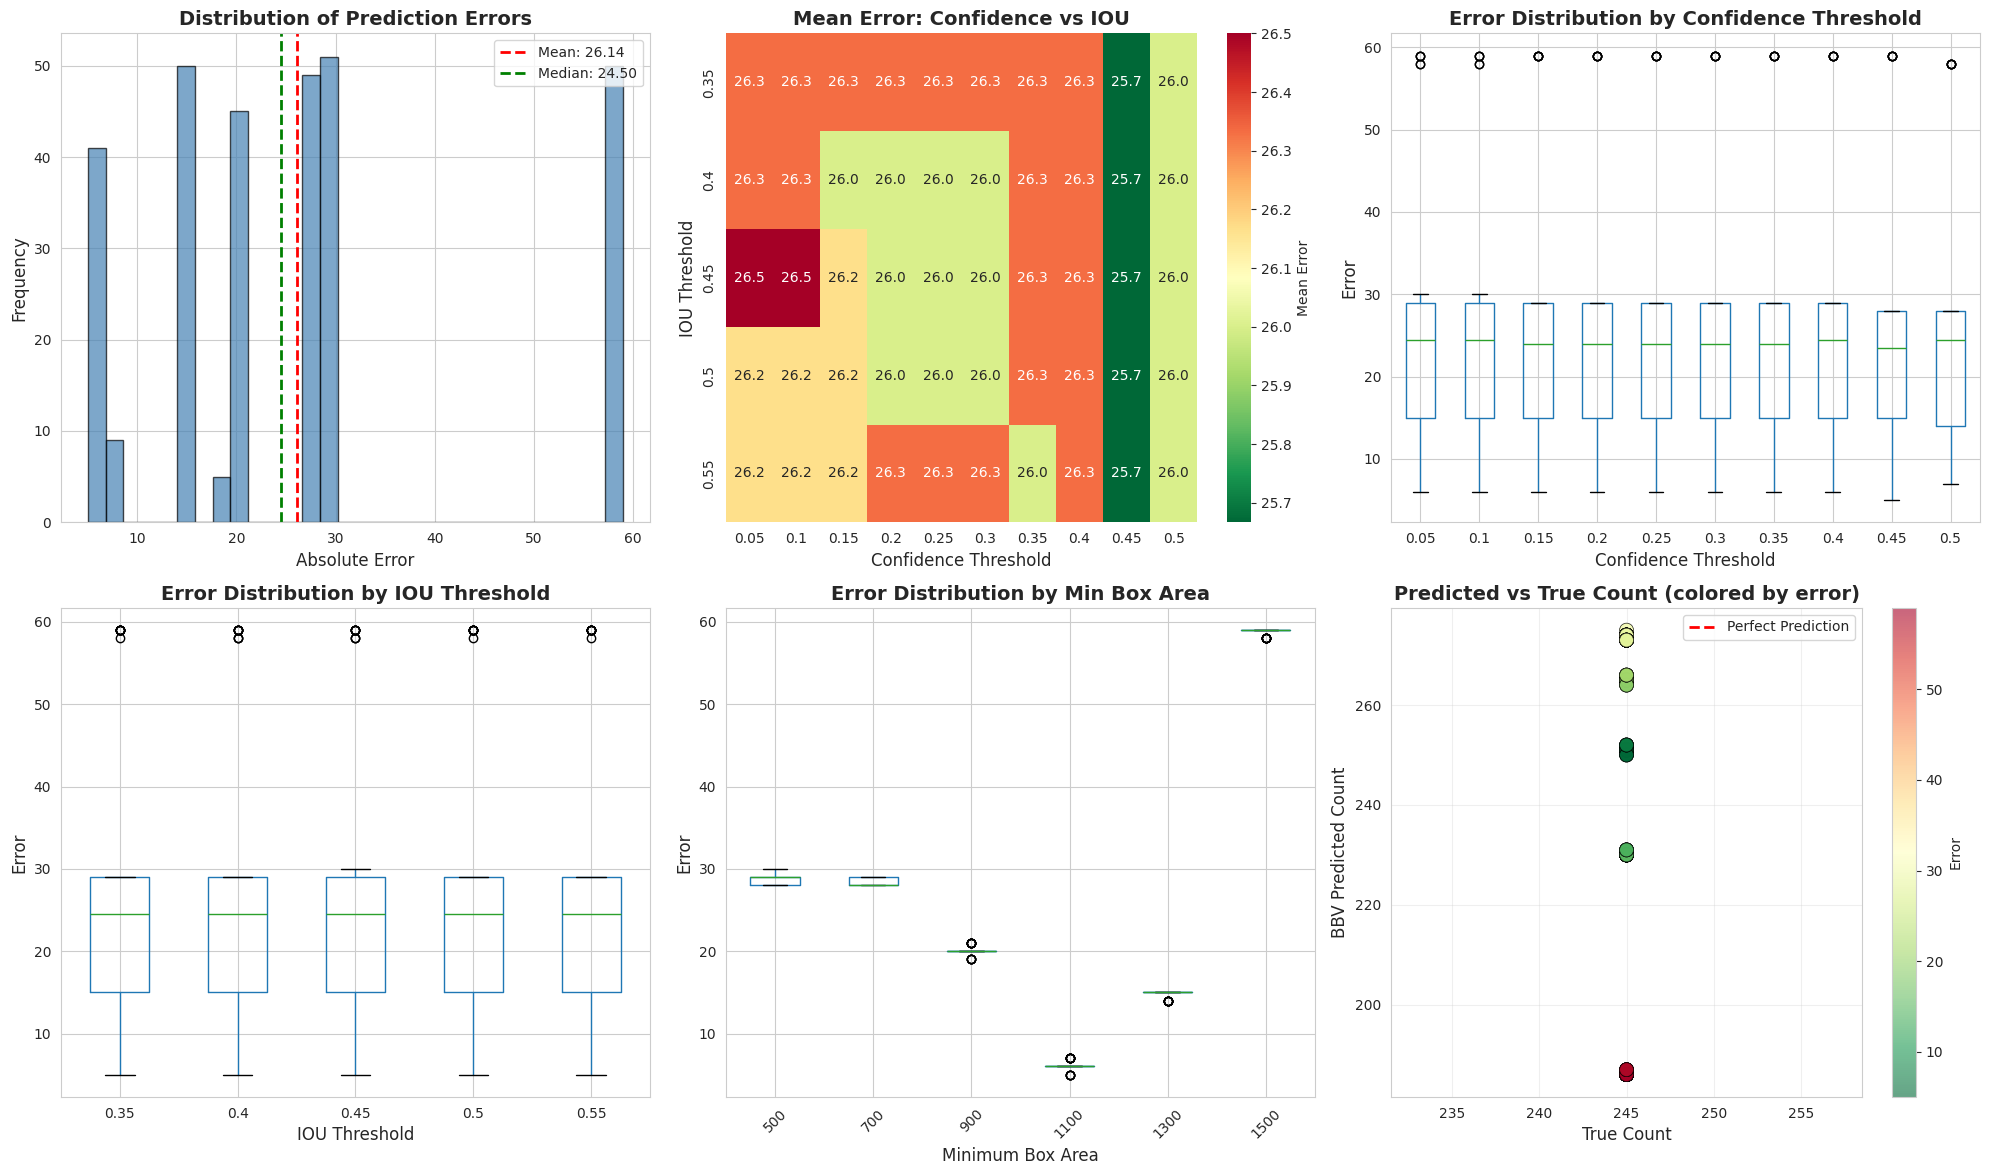


VISUALIZATION SAVED
Saved to: ./bbv-test-results2//parameter_performance_overview.png


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Load results from CSV
results_df = pd.read_csv(f"{base_output_path}/bbv_test_results_summary.csv")

# Create a comprehensive visualization dashboard
fig = plt.figure(figsize=(20, 12))

# 1. Error Distribution Histogram
ax1 = plt.subplot(2, 3, 1)
plt.hist(results_df['error'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Absolute Error', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Prediction Errors', fontsize=14, fontweight='bold')
plt.axvline(results_df['error'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {results_df["error"].mean():.2f}')
plt.axvline(results_df['error'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {results_df["error"].median():.2f}')
plt.legend()

# 2. Heatmap: Confidence vs IOU (averaged over min_box_area)
ax2 = plt.subplot(2, 3, 2)
pivot_conf_iou = results_df.groupby(['conf', 'iou'])['error'].mean().reset_index()
pivot_table = pivot_conf_iou.pivot(index='iou', columns='conf', values='error')
sns.heatmap(pivot_table, annot=True, fmt='.1f', cmap='RdYlGn_r', cbar_kws={'label': 'Mean Error'}, ax=ax2)
plt.title('Mean Error: Confidence vs IOU', fontsize=14, fontweight='bold')
plt.xlabel('Confidence Threshold', fontsize=12)
plt.ylabel('IOU Threshold', fontsize=12)

# 3. Box plot: Error by Confidence threshold
ax3 = plt.subplot(2, 3, 3)
results_df.boxplot(column='error', by='conf', ax=ax3)
plt.xlabel('Confidence Threshold', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.title('Error Distribution by Confidence Threshold', fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove default title

# 4. Box plot: Error by IOU threshold
ax4 = plt.subplot(2, 3, 4)
results_df.boxplot(column='error', by='iou', ax=ax4)
plt.xlabel('IOU Threshold', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.title('Error Distribution by IOU Threshold', fontsize=14, fontweight='bold')
plt.suptitle('')

# 5. Box plot: Error by Min Box Area
ax5 = plt.subplot(2, 3, 5)
results_df.boxplot(column='error', by='min_box_area', ax=ax5)
plt.xlabel('Minimum Box Area', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.title('Error Distribution by Min Box Area', fontsize=14, fontweight='bold')
plt.suptitle('')
plt.xticks(rotation=45)

# 6. Scatter: BBV Count vs True Count with error color coding
ax6 = plt.subplot(2, 3, 6)
scatter = plt.scatter(results_df['true_count'], results_df['bbv_count'], 
                     c=results_df['error'], cmap='RdYlGn_r', 
                     s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.plot([results_df['true_count'].min(), results_df['true_count'].max()], 
         [results_df['true_count'].min(), results_df['true_count'].max()], 
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('True Count', fontsize=12)
plt.ylabel('BBV Predicted Count', fontsize=12)
plt.title('Predicted vs True Count (colored by error)', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Error')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{base_output_path}/parameter_performance_overview.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n{'='*60}")
print("VISUALIZATION SAVED")
print(f"{'='*60}")
print(f"Saved to: {base_output_path}/parameter_performance_overview.png")

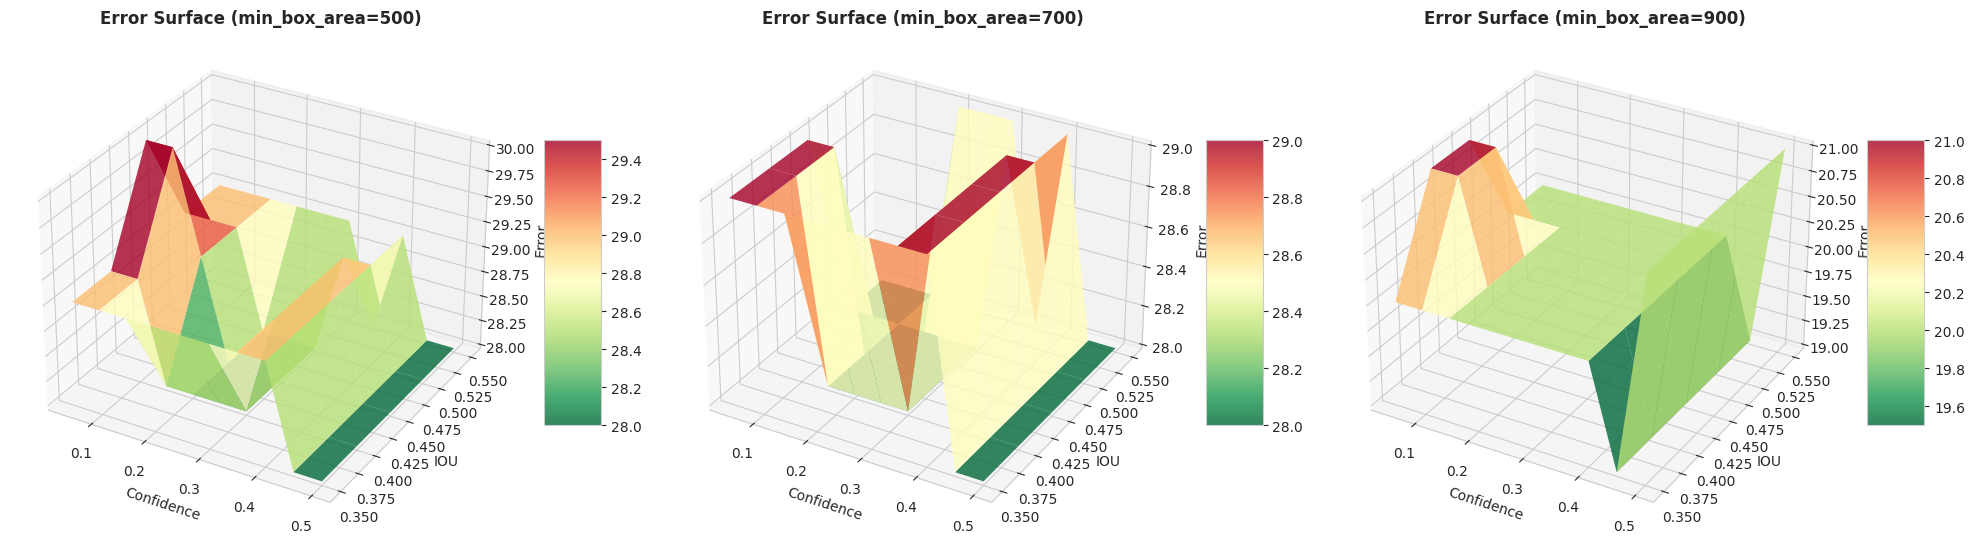

Saved 3D surface plots to: ./bbv-test-results2//3d_error_surfaces.png


In [8]:
# Additional detailed visualizations

# 1. 3D Surface plot showing relationship between conf, iou, and error
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 6))

# 3D Surface plot for each min_box_area
for idx, min_area in enumerate(sorted(results_df['min_box_area'].unique())):
    ax = fig.add_subplot(1, 3, idx % 3 + 1, projection='3d')
    
    subset = results_df[results_df['min_box_area'] == min_area]
    
    # Create mesh grid
    conf_vals = sorted(subset['conf'].unique())
    iou_vals = sorted(subset['iou'].unique())
    
    # Create pivot table for surface
    pivot = subset.pivot_table(values='error', index='iou', columns='conf', aggfunc='mean')
    
    X, Y = np.meshgrid(conf_vals, iou_vals)
    Z = pivot.values
    
    surf = ax.plot_surface(X, Y, Z, cmap='RdYlGn_r', alpha=0.8, edgecolor='none')
    
    ax.set_xlabel('Confidence', fontsize=10)
    ax.set_ylabel('IOU', fontsize=10)
    ax.set_zlabel('Error', fontsize=10)
    ax.set_title(f'Error Surface (min_box_area={min_area})', fontsize=12, fontweight='bold')
    
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    if idx == 2:
        break

plt.tight_layout()
plt.savefig(f"{base_output_path}/3d_error_surfaces.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Saved 3D surface plots to: {base_output_path}/3d_error_surfaces.png")

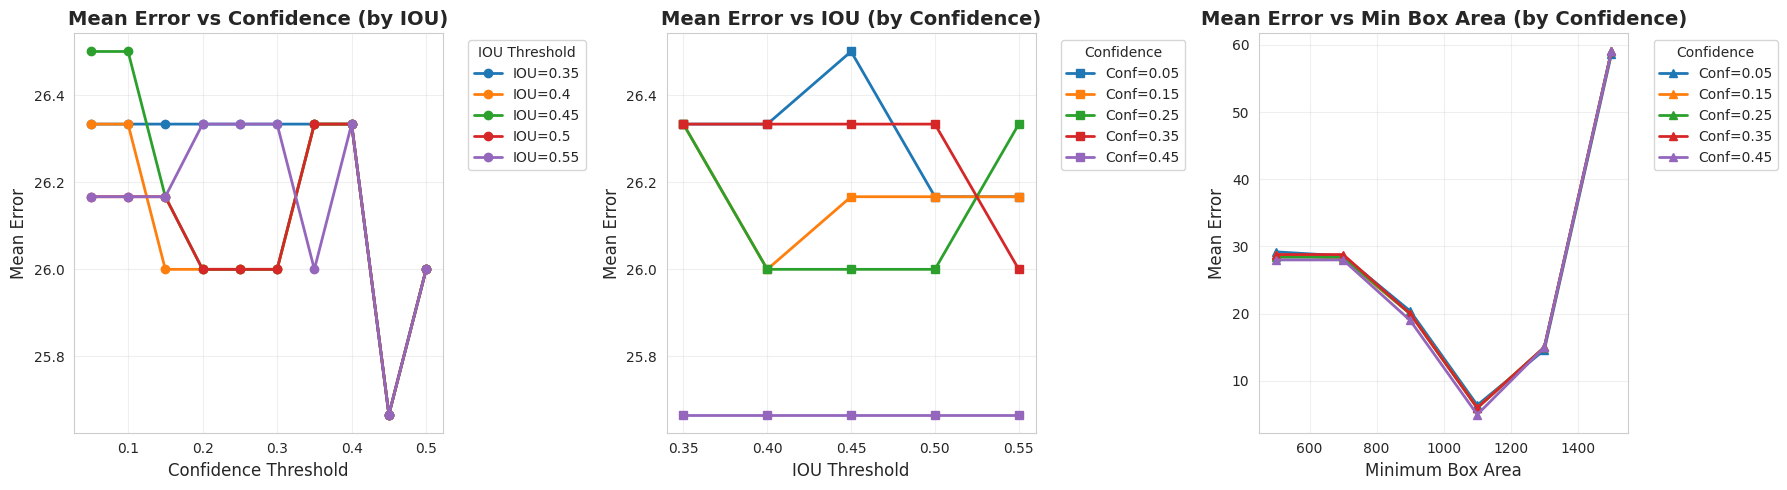

Saved parameter trend plots to: ./bbv-test-results2//parameter_trends.png


In [11]:
# Line plots showing parameter effects on error

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Error vs Confidence (grouped by IOU)
ax = axes[0]
for iou_val in sorted(results_df['iou'].unique()):
    subset = results_df[results_df['iou'] == iou_val]
    grouped = subset.groupby('conf')['error'].mean()
    ax.plot(grouped.index, grouped.values, marker='o', label=f'IOU={iou_val}', linewidth=2)

ax.set_xlabel('Confidence Threshold', fontsize=12)
ax.set_ylabel('Mean Error', fontsize=12)
ax.set_title('Mean Error vs Confidence (by IOU)', fontsize=14, fontweight='bold')
ax.legend(title='IOU Threshold', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

# 2. Error vs IOU (grouped by Confidence)
ax = axes[1]
for conf_val in sorted(results_df['conf'].unique())[::2]:  # Show every other confidence to avoid clutter
    subset = results_df[results_df['conf'] == conf_val]
    grouped = subset.groupby('iou')['error'].mean()
    ax.plot(grouped.index, grouped.values, marker='s', label=f'Conf={conf_val}', linewidth=2)

ax.set_xlabel('IOU Threshold', fontsize=12)
ax.set_ylabel('Mean Error', fontsize=12)
ax.set_title('Mean Error vs IOU (by Confidence)', fontsize=14, fontweight='bold')
ax.legend(title='Confidence', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

# 3. Error vs Min Box Area
ax = axes[2]
for conf_val in sorted(results_df['conf'].unique())[::2]:
    subset = results_df[results_df['conf'] == conf_val]
    grouped = subset.groupby('min_box_area')['error'].mean()
    ax.plot(grouped.index, grouped.values, marker='^', label=f'Conf={conf_val}', linewidth=2)

ax.set_xlabel('Minimum Box Area', fontsize=12)
ax.set_ylabel('Mean Error', fontsize=12)
ax.set_title('Mean Error vs Min Box Area (by Confidence)', fontsize=14, fontweight='bold')
ax.legend(title='Confidence', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{base_output_path}/parameter_trends.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Saved parameter trend plots to: {base_output_path}/parameter_trends.png")

STATISTICAL SUMMARY OF PARAMETER TESTING

Overall Performance:
  Total combinations tested: 300
  Mean error: 26.14
  Median error: 24.50
  Std deviation: 16.60
  Min error: 5.00
  Max error: 59.00

TOP 10 BEST PARAMETER COMBINATIONS
 conf  iou  min_box_area  bbv_count  error
 0.45 0.35          1100        250      5
 0.45 0.40          1100        250      5
 0.45 0.45          1100        250      5
 0.45 0.50          1100        250      5
 0.45 0.55          1100        250      5
 0.05 0.35          1100        251      6
 0.05 0.50          1100        251      6
 0.05 0.55          1100        251      6
 0.10 0.35          1100        251      6
 0.10 0.50          1100        251      6

WORST 5 PARAMETER COMBINATIONS
 conf  iou  min_box_area  bbv_count  error
 0.05 0.35          1500        186     59
 0.05 0.50          1500        186     59
 0.05 0.55          1500        186     59
 0.10 0.35          1500        186     59
 0.10 0.50          1500        186     59

BE

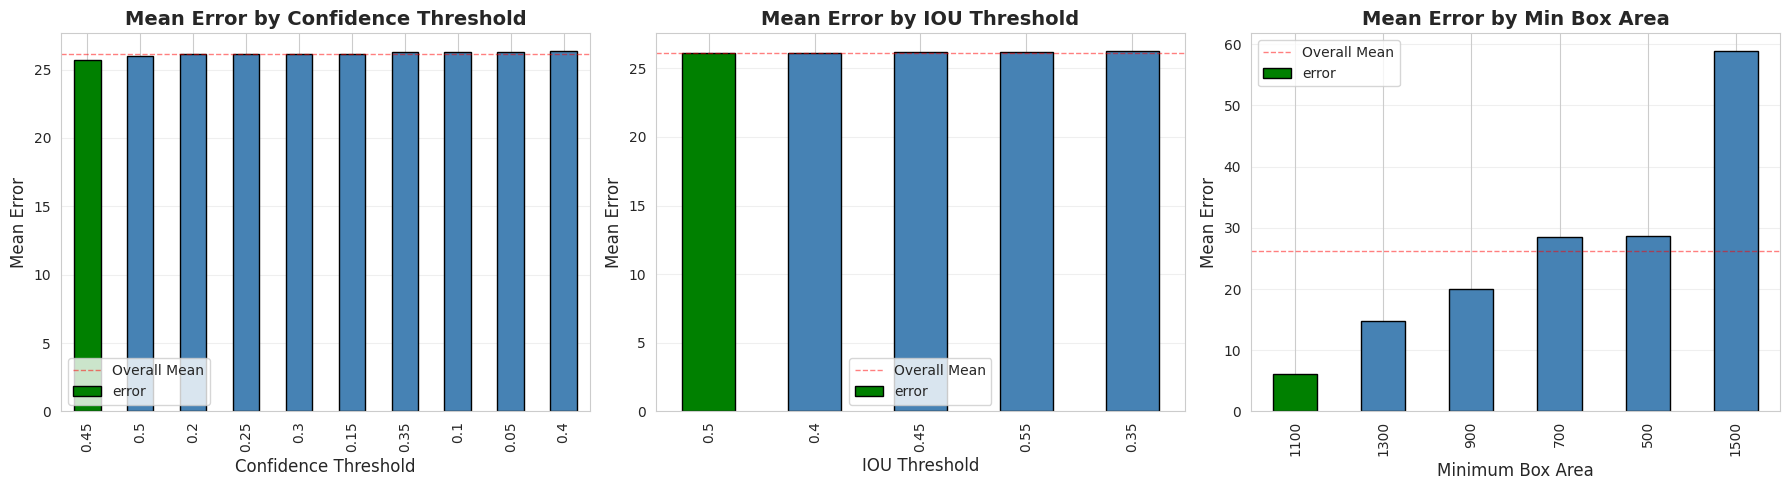


Saved best parameters summary to: ./bbv-test-results2//best_parameters_summary.png


In [9]:
# Statistical summary and top performers

print("="*80)
print("STATISTICAL SUMMARY OF PARAMETER TESTING")
print("="*80)

# Overall statistics
print(f"\nOverall Performance:")
print(f"  Total combinations tested: {len(results_df)}")
print(f"  Mean error: {results_df['error'].mean():.2f}")
print(f"  Median error: {results_df['error'].median():.2f}")
print(f"  Std deviation: {results_df['error'].std():.2f}")
print(f"  Min error: {results_df['error'].min():.2f}")
print(f"  Max error: {results_df['error'].max():.2f}")

# Top 10 best performers
print(f"\n{'='*80}")
print("TOP 10 BEST PARAMETER COMBINATIONS")
print("="*80)
top_10 = results_df.nsmallest(10, 'error')[['conf', 'iou', 'min_box_area', 'bbv_count', 'error']]
print(top_10.to_string(index=False))

# Worst 5 performers
print(f"\n{'='*80}")
print("WORST 5 PARAMETER COMBINATIONS")
print("="*80)
worst_5 = results_df.nlargest(5, 'error')[['conf', 'iou', 'min_box_area', 'bbv_count', 'error']]
print(worst_5.to_string(index=False))

# Best parameters by each dimension
print(f"\n{'='*80}")
print("BEST PARAMETERS BY DIMENSION")
print("="*80)

best_conf = results_df.groupby('conf')['error'].mean().idxmin()
print(f"\nBest Confidence threshold: {best_conf} (mean error: {results_df.groupby('conf')['error'].mean()[best_conf]:.2f})")

best_iou = results_df.groupby('iou')['error'].mean().idxmin()
print(f"Best IOU threshold: {best_iou} (mean error: {results_df.groupby('iou')['error'].mean()[best_iou]:.2f})")

best_area = results_df.groupby('min_box_area')['error'].mean().idxmin()
print(f"Best Min Box Area: {best_area} (mean error: {results_df.groupby('min_box_area')['error'].mean()[best_area]:.2f})")

# Create a summary visualization showing best parameters
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Bar plot for mean error by confidence
ax = axes[0]
conf_errors = results_df.groupby('conf')['error'].mean().sort_values()
colors = ['green' if x == best_conf else 'steelblue' for x in conf_errors.index]
conf_errors.plot(kind='bar', ax=ax, color=colors, edgecolor='black')
ax.set_xlabel('Confidence Threshold', fontsize=12)
ax.set_ylabel('Mean Error', fontsize=12)
ax.set_title('Mean Error by Confidence Threshold', fontsize=14, fontweight='bold')
ax.axhline(y=conf_errors.mean(), color='red', linestyle='--', linewidth=1, alpha=0.5, label='Overall Mean')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Bar plot for mean error by IOU
ax = axes[1]
iou_errors = results_df.groupby('iou')['error'].mean().sort_values()
colors = ['green' if x == best_iou else 'steelblue' for x in iou_errors.index]
iou_errors.plot(kind='bar', ax=ax, color=colors, edgecolor='black')
ax.set_xlabel('IOU Threshold', fontsize=12)
ax.set_ylabel('Mean Error', fontsize=12)
ax.set_title('Mean Error by IOU Threshold', fontsize=14, fontweight='bold')
ax.axhline(y=iou_errors.mean(), color='red', linestyle='--', linewidth=1, alpha=0.5, label='Overall Mean')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Bar plot for mean error by min box area
ax = axes[2]
area_errors = results_df.groupby('min_box_area')['error'].mean().sort_values()
colors = ['green' if x == best_area else 'steelblue' for x in area_errors.index]
area_errors.plot(kind='bar', ax=ax, color=colors, edgecolor='black')
ax.set_xlabel('Minimum Box Area', fontsize=12)
ax.set_ylabel('Mean Error', fontsize=12)
ax.set_title('Mean Error by Min Box Area', fontsize=14, fontweight='bold')
ax.axhline(y=area_errors.mean(), color='red', linestyle='--', linewidth=1, alpha=0.5, label='Overall Mean')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f"{base_output_path}/best_parameters_summary.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nSaved best parameters summary to: {base_output_path}/best_parameters_summary.png")

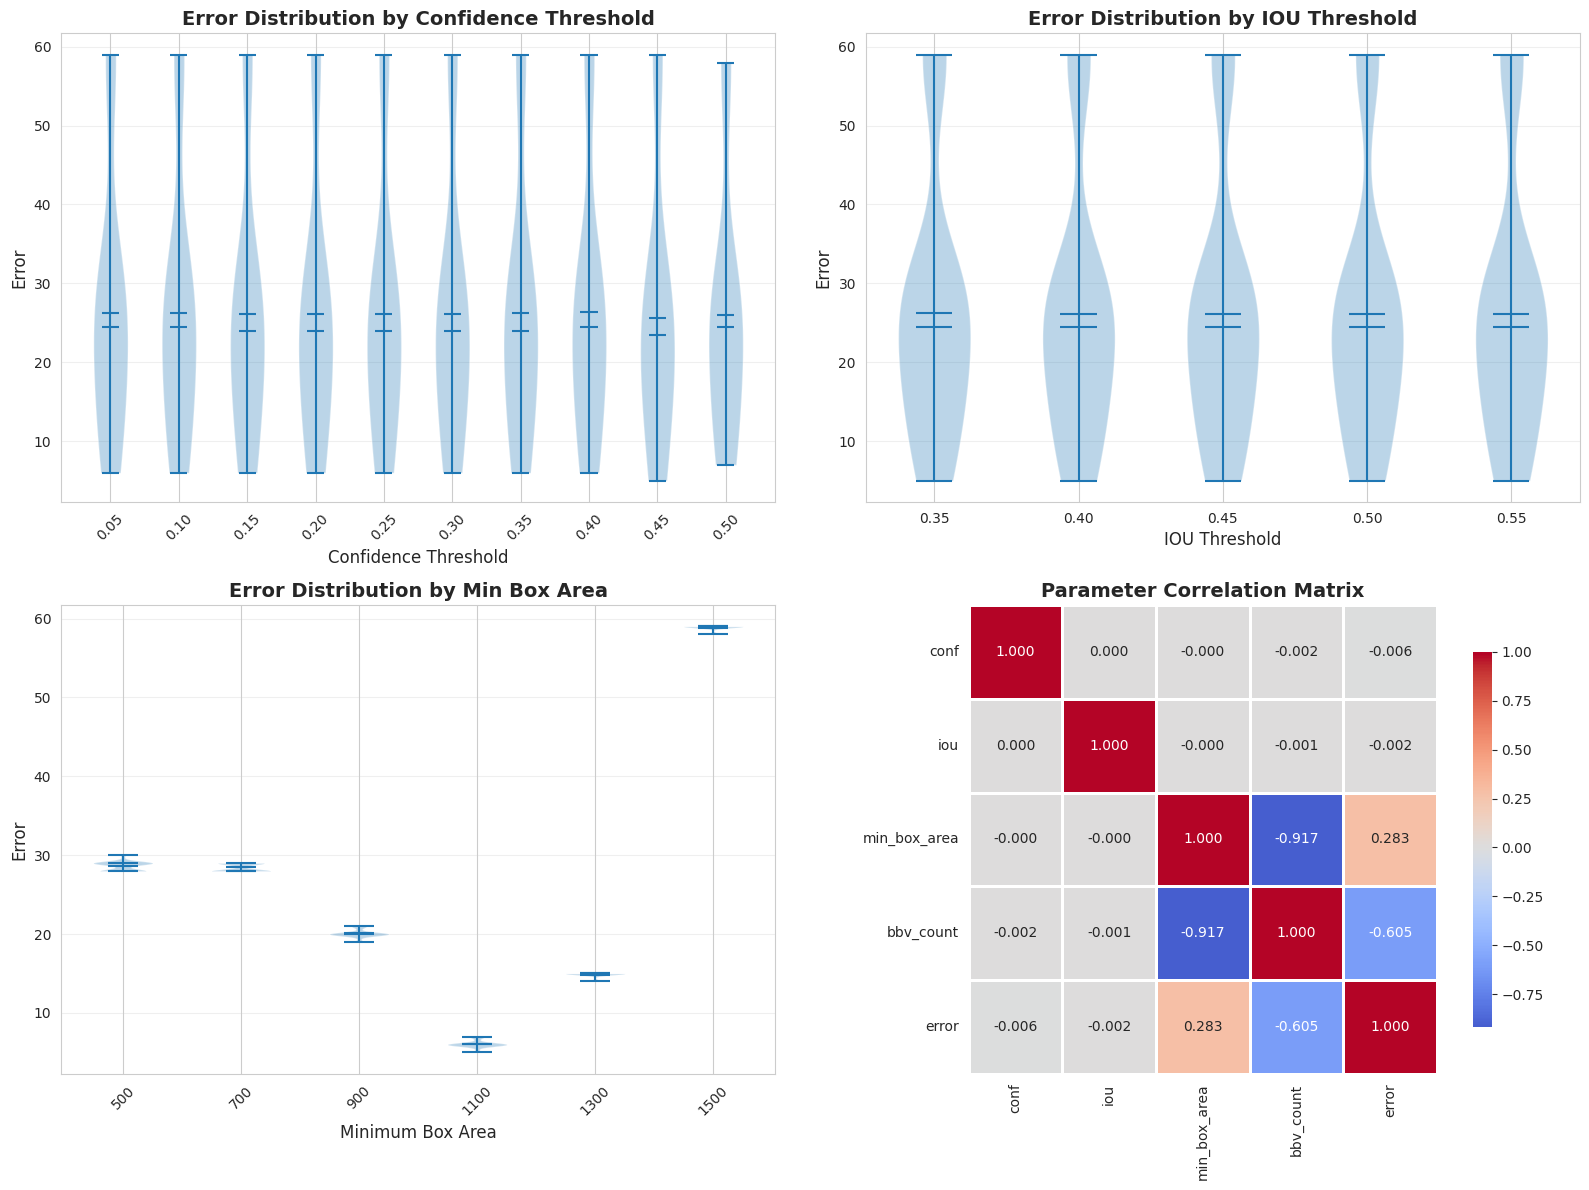

Saved detailed distribution plots to: ./bbv-test-results2//detailed_distributions.png


In [10]:
# Violin plots for detailed distribution analysis

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Violin plot for Confidence
ax = axes[0, 0]
conf_data = [results_df[results_df['conf'] == c]['error'].values for c in sorted(results_df['conf'].unique())]
parts = ax.violinplot(conf_data, positions=range(len(results_df['conf'].unique())), 
                       showmeans=True, showmedians=True)
ax.set_xticks(range(len(results_df['conf'].unique())))
ax.set_xticklabels([f'{c:.2f}' for c in sorted(results_df['conf'].unique())], rotation=45)
ax.set_xlabel('Confidence Threshold', fontsize=12)
ax.set_ylabel('Error', fontsize=12)
ax.set_title('Error Distribution by Confidence Threshold', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# 2. Violin plot for IOU
ax = axes[0, 1]
iou_data = [results_df[results_df['iou'] == i]['error'].values for i in sorted(results_df['iou'].unique())]
parts = ax.violinplot(iou_data, positions=range(len(results_df['iou'].unique())), 
                       showmeans=True, showmedians=True)
ax.set_xticks(range(len(results_df['iou'].unique())))
ax.set_xticklabels([f'{i:.2f}' for i in sorted(results_df['iou'].unique())])
ax.set_xlabel('IOU Threshold', fontsize=12)
ax.set_ylabel('Error', fontsize=12)
ax.set_title('Error Distribution by IOU Threshold', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# 3. Violin plot for Min Box Area
ax = axes[1, 0]
area_data = [results_df[results_df['min_box_area'] == a]['error'].values for a in sorted(results_df['min_box_area'].unique())]
parts = ax.violinplot(area_data, positions=range(len(results_df['min_box_area'].unique())), 
                       showmeans=True, showmedians=True)
ax.set_xticks(range(len(results_df['min_box_area'].unique())))
ax.set_xticklabels([f'{a}' for a in sorted(results_df['min_box_area'].unique())], rotation=45)
ax.set_xlabel('Minimum Box Area', fontsize=12)
ax.set_ylabel('Error', fontsize=12)
ax.set_title('Error Distribution by Min Box Area', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# 4. Combined correlation heatmap
ax = axes[1, 1]
# Create correlation matrix
corr_data = results_df[['conf', 'iou', 'min_box_area', 'bbv_count', 'error']].corr()
sns.heatmap(corr_data, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Parameter Correlation Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{base_output_path}/detailed_distributions.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Saved detailed distribution plots to: {base_output_path}/detailed_distributions.png")